In [1]:
import numpy as np
import pandas as pd
import math
from random import sample
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import imgaug
from skimage import io

In [2]:
#data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification'    
data_dir = 'data'
image_width = 600
image_height = 600
channels = 3

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_train_full = pd.concat([df_train_full, df_extra], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [4]:
df_train_full.label.unique()

array(['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], dtype=object)

In [5]:
df_train_full.label.value_counts()

plate    1698
cup      1625
spoon    1512
knife    1357
glass    1020
fork      776
Name: label, dtype: int64

In [6]:
df_fork = df_train_full.query('label == "fork"').copy()
df_fork.reset_index(drop=True, inplace = True)
df_fork

,Id,label,filename
0,6446,fork,data/images/6446.jpg
1,1228,fork,data/images/1228.jpg
2,1279,fork,data/images/1279.jpg
3,2112,fork,data/images/2112.jpg
4,0598,fork,data/images/0598.jpg
...,...,...,...
771,eu.b9ed486c-9309-44d7-b1f3-e31e6790ad4f,fork,data/images/eu.b9ed486c-9309-44d7-b1f3-e31e679...
772,eu.c66ceb6b-a5c9-40ab-a0f4-400b75a0c1e8,fork,data/images/eu.c66ceb6b-a5c9-40ab-a0f4-400b75a...
773,eu.f1145f78-76be-4a98-a281-4f39034c7e71,fork,data/images/eu.f1145f78-76be-4a98-a281-4f39034...
774,eu.0124549f-b1d5-41b2-aad5-b91e3e5ec985,fork,data/images/eu.0124549f-b1d5-41b2-aad5-b91e3e5...


In [7]:
forks = []
for filename in df_fork.filename:
    image = io.imread(filename)
    forks.append(image)


In [8]:
train_aug = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1.0),
        iaa.Flipud(1.0), # vertically flip images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.5, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.5, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.5, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug"
)

In [9]:
train_aug1 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1.0),
        #iaa.Flipud(1.0), # vertically flip images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Cutout(nb_iterations = (2, 5), size = (.07, .2)),
        iaa.Sometimes(0.7, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.7, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.8, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.5, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug1"
)

In [10]:
train_aug2 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(0.6),
        iaa.Flipud(0.6), # vertically flip images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.7, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.7, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.8, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.imgcorruptlike.GaussianNoise(severity=(1,4)),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug2"
)

In [11]:
train_aug3 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(0.6),
        iaa.Flipud(0.6), # vertically flip images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.GammaContrast((0.5, 1.0), per_channel=True),
        iaa.Sometimes(0.7, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50)))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.imgcorruptlike.GaussianNoise(severity=(1,4)),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug3"
)

In [12]:
train_aug4 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(0.6),
        iaa.Flipud(0.6), # vertically flip images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.7, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.7, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50)))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.imgcorruptlike.GaussianNoise(severity=(1,4)),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug4"
)

In [13]:
train_aug5 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(0.6),
        iaa.Flipud(0.6), # vertically flip images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.5, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.5, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.5, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        iaa.imgcorruptlike.Frost(severity=2),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug5"
)

In [14]:
forks_aug = train_aug(images = forks)
forks_aug += train_aug1(images = sample(forks, 150))
#forks_aug += train_aug2(images = forks)
#forks_aug += train_aug3(images = forks)
#forks_aug += train_aug4(images = forks)
#forks_aug += train_aug5(images = sample(forks, 500))

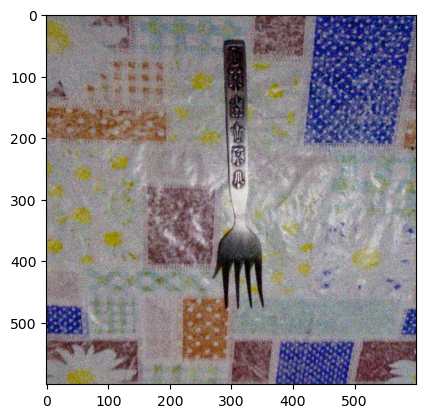

In [15]:
image = forks_aug[361]
plt.imshow(image)

In [16]:
np.asarray(forks_aug).shape

(926, 600, 600, 3)

In [17]:
len(forks_aug)

926

In [18]:
df_fork_aug = pd.DataFrame(columns = ['Id', 'label'], dtype = str)
for i in range(len(forks_aug)):
    file_name = 'fork_aug_'+str(i)
    io.imsave(data_dir+'/images/'+file_name+'.jpg', forks_aug[i])
    df_fork_aug.loc[len(df_fork_aug)] = ['fork_aug_'+str(i), 'fork']
    
df_fork_aug

,Id,label
0,fork_aug_0,fork
1,fork_aug_1,fork
2,fork_aug_2,fork
3,fork_aug_3,fork
4,fork_aug_4,fork
...,...,...
921,fork_aug_921,fork
922,fork_aug_922,fork
923,fork_aug_923,fork
924,fork_aug_924,fork


In [19]:
df_fork_aug.to_csv(data_dir+'/forks_aug.csv', index = False)

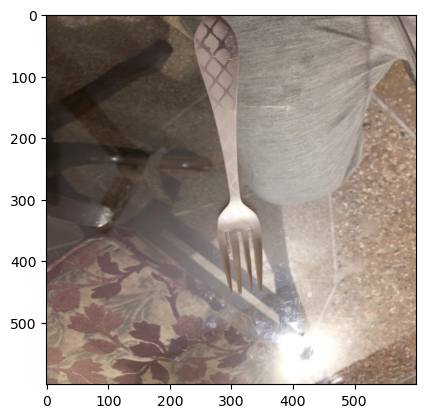

In [20]:
image = forks_aug[700]
plt.imshow(image)